In [1]:
%matplotlib notebook

import sys
import os
import time
from importlib import reload

In [2]:
import numpy as np
import qcodes as qc
import broadbean as bb

from matplotlib import pyplot as plt
from broadbean.plotting import plotter

In [3]:
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.dataset.data_set import DataSet
from qcodes.sweep import sweep, nest, chain, szip, getter, setter
from qcodes.sweep.sweep import ParameterSweep, Nest, ParameterWrapper, FunctionWrapper, FunctionSweep, getter

In [4]:
from pytopo.qctools import instruments as instools; reload(instools)
from pytopo.qctools.instruments import create_inst, add2station

from pytopo.mplplots.init_nb_plotting import *
from pytopo.mplplots import plots as mplplots
from pytopo.mplplots import tools as mpltools

In [5]:
import plottr; reload(plottr)

from pytopo.qctools.dataset2 import select_experiment
from plottr.qcodes_dataset import QcodesDatasetSubscriber

# Init

## load instruments

In [ ]:
# %run init_cQED.py

In [7]:
### Init instruments
from pytopo.rf.alazar_acquisition import RawAcqCtl, DemodAcqCtl, DemodRelAcqCtl, IQRelAcqCtl, IQAcqCtl

inst_list = []

from qcodes.instrument_drivers.AlazarTech.ATS9360 import AlazarTech_ATS9360
alazar = instools.create_inst(AlazarTech_ATS9360, 'alazar')
inst_list.append(alazar)

raw_acq = instools.create_inst(RawAcqCtl, 'raw_acq', 'alazar', force_new_instance=True)
inst_list.append(raw_acq)

demod_acq = instools.create_inst(DemodAcqCtl, 'demod_acq', 'alazar', force_new_instance=True)
inst_list.append(demod_acq)

demodrel_acq = instools.create_inst(DemodRelAcqCtl, 'rel_acq', 'alazar', force_new_instance=True)
inst_list.append(demodrel_acq)

iqrel_acq = instools.create_inst(IQRelAcqCtl, 'iqrel_acq', 'alazar', force_new_instance=True)
inst_list.append(iqrel_acq)

iq_acq = instools.create_inst(IQAcqCtl, 'iq_acq', 'alazar', force_new_instance=True)
inst_list.append(iq_acq)

from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg5014 = instools.create_inst(Tektronix_AWG5014, 'awg5014', address="TCPIP0::169.254.220.147::inst0::INSTR")
inst_list.append(awg5014)

from qcodes.instrument_drivers.rohde_schwarz.SGS100A import RohdeSchwarz_SGS100A
LO = instools.create_inst(RohdeSchwarz_SGS100A, 'LO', address="TCPIP0::169.254.2.20")
inst_list.append(LO)
RF = instools.create_inst(RohdeSchwarz_SGS100A, 'RF', address="TCPIP0::169.254.231.38")
inst_list.append(RF)
qubit_gen = instools.create_inst(RohdeSchwarz_SGS100A, 'qubit_gen', address="TCPIP0::169.254.167.18")
inst_list.append(qubit_gen)

# from qcodes.instrument_drivers.yokogawa.GS200 import GS200
# yoko = instools.create_inst(GS200, 'yoko', address="TCPIP0::169.254.1.9::inst0::INSTR")
# inst_list.append(yoko)

station = qc.Station(*inst_list)

Connected to: TEKTRONIX AWG5014C (serial:B051389, firmware:SCPI:99.0 FW:4.6.0.7) in 0.66s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110509, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110510, firmware:3.1.19.15-3.50.124.67) in 0.04s
Connected to: Rohde&Schwarz SGS100A (serial:1416.0505k02/110531, firmware:3.1.19.15-3.50.124.67) in 0.04s


Snapshot: Could not update parameter:clock_source
Snapshot: Could not update parameter:external_sample_rate
Snapshot: Could not update parameter:sample_rate
Snapshot: Could not update parameter:clock_edge
Snapshot: Could not update parameter:decimation
Snapshot: Could not update parameter:coupling1
Snapshot: Could not update parameter:channel_range1
Snapshot: Could not update parameter:impedance1
Snapshot: Could not update parameter:coupling2
Snapshot: Could not update parameter:channel_range2
Snapshot: Could not update parameter:impedance2
Snapshot: Could not update parameter:trigger_operation
Snapshot: Could not update parameter:trigger_engine1
Snapshot: Could not update parameter:trigger_source1
Snapshot: Could not update parameter:trigger_slope1
Snapshot: Could not update parameter:trigger_level1
Snapshot: Could not update parameter:trigger_engine2
Snapshot: Could not update parameter:trigger_source2
Snapshot: Could not update parameter:trigger_slope2
Snapshot: Could not update par

## Default settings

In [8]:
ats_settings = dict(
    clock_source='INTERNAL_CLOCK',
    sample_rate=int(2e8),
    clock_edge='CLOCK_EDGE_RISING',
    decimation=1,
    coupling=['DC','DC'],
    channel_range=[.4, .4],
    impedance=[50, 50],
    trigger_operation='TRIG_ENGINE_OP_J',
    trigger_engine1='TRIG_ENGINE_J',
    trigger_source1='EXTERNAL',
    trigger_slope1='TRIG_SLOPE_POSITIVE',
    trigger_level1=128+20,
    trigger_engine2='TRIG_ENGINE_K',
    trigger_source2='DISABLE',
    trigger_slope2='TRIG_SLOPE_POSITIVE',
    trigger_level2=128+5,
    external_trigger_coupling='DC',
    external_trigger_range='ETR_2V5',
    trigger_delay=0,
    timeout_ticks=int(1e7),
    aux_io_mode='AUX_IN_AUXILIARY',
    aux_io_param='NONE',
)

station.alazar.config(**ats_settings)

# yoko.range(10)
# yoko.voltage(0)
# yoko.on()

## Global settings

In [9]:
SAMPLE = 'ref_transmon_CD20180510'

## Tools

In [10]:
from pytopo.qctools import hard_sweep; reload(hard_sweep)
from pytopo.qctools.hard_sweep import HardSweep, HardSweepDetector

In [ ]:
from qcodes.instrument.base import Instrument

class IFController(Instrument):
    
    def __init__(self, name, rf_inst, lo_inst, **kw):
        super().__init__(name, **kw)
        
        self.rf = rf_inst
        self.lo = lo_inst
        
        pass

### Pulse sequencer

In [11]:
ramp = bb.PulseAtoms.ramp

class BluePrints(object):
    
    def __init__(self, chan_map, sample_rate=1e9):
        self.bps = {}
        self.map = {}
        
        for i, lst in chan_map.items():
            self.bps[i] = bb.BluePrint()
            self.bps[i].setSR(sample_rate)
            for j, name in enumerate(lst):
                if name is not None:
                    self.map[name] = (i, j)
                    
    def __getitem__(self, name):
        if self.map[name][1] == 0:
            return self.bps[self.map[name][0]]
        else:
            return getattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]))
        
    def __setitem__(self, name, value):
        if self.map[name][1] == 0:
            self.bps[self.map[name][0]] = value
        else:
            setattr(self.bps[self.map[name][0]], 'marker{}'.format(self.map[name][1]), value)
        
    def __call__(self):
        return list(self.bps.items())
    

class BroadBeanSequence(HardSweep):
    
    chan_map = {}
    
    def __init__(self, name, awg, chan_map, **kw):
        self.awg = awg
        self.chan_map = chan_map
        
        super().__init__(name, **kw)
        
        self.add_parameter('sample_rate', get_cmd=None, set_cmd=None, 
                           unit='GS/s', initial_value=1e9)
        
    def sequence(self):
        raise NotImplementedError
        
        
    def setup(self):
        super().setup()
        
        self.awg.stop()
        self.awg.clock_freq(self.sample_rate())
        
        seq = self.sequence()
        pkg = seq.outputForAWGFile()
        self.awg.make_send_and_load_awg_file(*pkg[:])
        
        for ch_no, ch_desc in self.chan_map.items():
            self.awg.set('ch{}_state'.format(ch_no), 1)

        self.awg.start()

        
class SimpleAWGSpec(BroadBeanSequence):

    def __init__(self, *arg, **kw):
        
        kw['sweep_dims'] = ['awg_sweep_idx', ]
        
        super().__init__(*arg, **kw)
        
        self.add_parameter('initial_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)
        self.add_parameter('alazar_trigger_len', set_cmd=None,
                           unit='s', initial_value=1e-7)
        self.add_parameter('alazar_trigger_delay', set_cmd=None, 
                           unit='s', initial_value=1e-6)
        self.add_parameter('seq_len', set_cmd=None, 
                           unit='s', initial_value=1e-5)
        self.add_parameter('final_delay', set_cmd=None,
                           unit='s', initial_value=1e-6)

    def setup(self):
        self.awg_sweep_idx([1,])
        super().setup()
        
    def sequence(self):
        elem = bb.Element()
        
        bps = BluePrints(self.chan_map, sample_rate=self.sample_rate())
        
        bps['ro'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='ro_segment')
        bps['alz_mrkr'] = [(self.initial_delay(), self.alazar_trigger_len())]
        bps['ro_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
                           self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
        bps['q'].insertSegment(0, ramp, (0, 0), dur=self.seq_len(), name='q_segment')
        bps['q_mrkr'] = [(self.initial_delay() + self.alazar_trigger_delay(), 
                          self.seq_len() - self.initial_delay() - 2 * self.alazar_trigger_delay() - self.final_delay(), )]
        
        
        for n, bp in bps():
            elem.addBluePrint(n, bp)
            
        seq = bb.Sequence()
        seq.name = 'spec'
        seq.addElement(1, elem)
        seq.setSR(self.sample_rate())
        
        seq.setChannelAmplitude(1, 1)
        seq.setChannelOffset(1, 0)
        seq.setChannelAmplitude(2, 1)
        seq.setChannelOffset(2, 0)

        seq.setSequencingTriggerWait(1, 0)
        seq.setSequencingGoto(1, 1)
        
        return seq

### Alazar Detector

In [12]:
class AlazarDetector(HardSweepDetector):
    
    def __init__(self, name, acqctl, sweep_params=['buffers', 'records'], **kwargs):
        self.acqctl = acqctl        
        self._time = None
        self._signal_real = None
        self._signal_imag = None        

        inner_dims = []
        for d in self.acqctl.data_dims():
            if d not in sweep_params:
                inner_dims.append(d)
        
        super().__init__(name, inner_dims=inner_dims, **kwargs)
        
        self.add_parameter('acquisition', get_cmd=self.do_acquisition, unit='V', snapshot_value=False)
        self.add_parameter('signal_real', get_cmd=lambda: self._signal_real, unit='V', snapshot_value=False)
        self.add_parameter('signal_imag', get_cmd=lambda: self._signal_imag, unit='V', snapshot_value=False)
        self.data_params = [self.signal_real, self.signal_imag]
        
        if 'samples' in self.inner_dims or 'IF_periods' in self.inner_dims:
            self.add_parameter('time', unit='s', snapshot_value=False, 
                               get_cmd=lambda: self._time)

    def setup(self):
        for d in self.inner_dims:
            idx = self.acqctl.data_dims().index(d)
            try:
                npts = self.acqctl.data_shape()[idx]
            except:
                npts = 1
            self.set(d, np.arange(npts))
            
        super().setup()
    
    
    def do_acquisition(self):
        data = self.acqctl.acquisition()
        self.setup()        
        
        if 'samples' in self.inner_dims:
            self._time = self.acqctl.tvals
        elif 'IF_periods' in self.inner_dims:
            self._time = self.acqctl.demod_tvals
            
        self._signal_real = np.real(data)
        self._signal_imag = np.imag(data)
        
        return data

# CW spec

## set up sweeps/detectors

In [44]:
# channel map. note that at this moment the analog channels are required, even if we don't do anything with them.
awg_chan_map = {
        1 : ['ro', 'alz_mrkr', 'ro_mrkr'],
        2 : ['q', 'q_mrkr', None],
    }

# create the meta-instrument for the sequence, add to the qcodes station.
awg_spec_sweep = create_inst(SimpleAWGSpec, 'awg_spec_sweep', awg=awg5014, chan_map=awg_chan_map, force_new_instance=True)
station = add2station(station, awg_spec_sweep)

# meta-instrument for the detector (i.e., alazar acquisition)
ctl = iqrel_acq
spec_detector = create_inst(AlazarDetector, name='spec_detector', acqctl=ctl, 
                            sweep_params=[], force_new_instance=True)

station = add2station(station, spec_detector)
spec_detector.set_sweeper(awg_spec)

Instrument awg_spec_sweep already exists.
Instrument spec_detector already exists.


## AWG sequence (to trigger Alazar)

In [42]:
# AWG sampling rate (in Hz)
awg_spec_sweep.sample_rate(1e9)

# sequence length (in s). Up to buffers at the edges this is the integration time per AWG sweep.
awg_spec_sweep.seq_len(100e-6)

# and setup the sequence (will program the awg)
awg_spec_sweep.setup()

## Test Alazar signal

In [14]:
generic_detector = create_inst(AlazarDetector, name='generic_detector', acqctl=demodrel_acq, 
                               sweep_params=[], force_new_instance=True)
station = add2station(station, generic_detector)

<IPython.core.display.Javascript object>


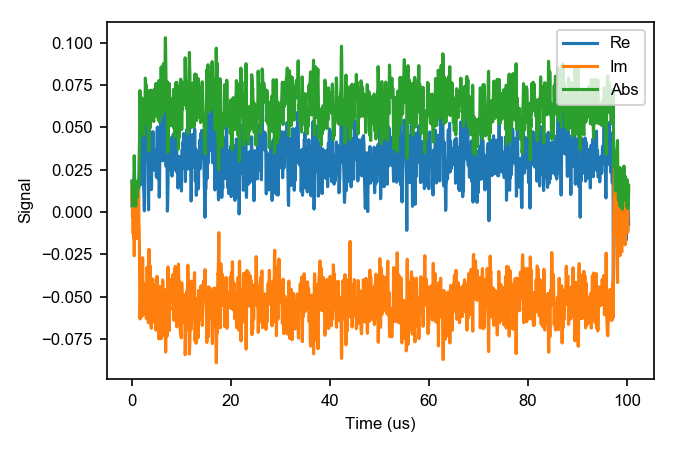

In [15]:
demodrel_acq.acq_time(100e-6)
demodrel_acq.demod_frq(20e6)
demodrel_acq.update_acquisitionkwargs(records_per_buffer=10, 
                                      buffers_per_acquisition=1,
                                      buffer_timeout=10000,
                                      allocated_buffers=1)

rawdata = generic_detector.acquisition()
data = np.squeeze(rawdata).mean(axis=0).reshape(-1)


fig, ax = plt.subplots(1, 1)
ax.plot(generic_detector.time() * 1e6, data.real, label='Re')
ax.plot(generic_detector.time() * 1e6, data.imag, label='Im')
ax.plot(generic_detector.time() * 1e6, np.abs(data), label='Abs')
ax.legend()

ax.set_ylabel('Signal')
ax.set_xlabel('Time (us)')

fig.tight_layout()

## RO spec

### Experiment settings

In [ ]:
# demod frequency
IF = 20e6

# experiment name
exp = select_experiment('readout_spec', SAMPLE)

In [45]:
### configure everything using the settings

# Configure Alazar acquisition controller
# acquisition time
ctl.acq_time(awg_spec_sweep.seq_len())

# demod frequency
ctl.demod_frq(IF)

# HW config, and how data is shaped.
ctl.update_acquisitionkwargs(
    # no sweep in the AWG here, so only 1 record
    records_per_buffer=1, 
    
    # this is for averaging by repeating the sequence; ie, number of averages per 'shot'.
    buffers_per_acquisition=10,
    
    # leave as is for now.
    buffer_timeout=10000,
    allocated_buffers=1
)
# yoko.on()
# yoko.ramp_voltage(0.0, 1e-3, 0.01)

In [46]:
### Run params
# Spectroscopy frequencies
rf_frqs = np.linspace(7.148e9, 7.152e9, 81)[:]

# setup the detector
spec_detector.setup()

# after setting up, we can create the measurement object.
# Note: we need to tell it ALL parameters and how they are related. 
# For simple cases, this wrapper does it.
meas = hard_sweep.make_measurement('results', exp=exp, 
                                   hard_sweep_detector=spec_detector,
                                   soft_sweep_params=[RF.frequency, ])

# how often we write to the database
meas.write_period = 1

# the measurement loop
with meas.run() as datasaver:
    # this enables live plotting with the plottr
    datasaver.dataset.subscribe(
        QcodesDatasetSubscriber(datasaver.dataset), 
        state=[], min_wait=0, min_count=1,
    )
    
    # software sweep of the RF frequency
    for f in rf_frqs:
        RF.frequency(f)
        LO.frequency(f + IF)
        time.sleep(0.2)
        
        # this runs the Alazar, and returns demodulated data.
        spec_detector.acquisition()
        
        # now that the data is here, we can pass the data to the dataset
        # get all sweep params in the right format (depends on the acquisition controller we use)
        # this is important so we know how to get data back in the right shape
        result = spec_detector.get_sweep_coords()
        
        # add also the soft sweep params...
        result += [(RF.frequency, f)]
        
        # and add the data
        result += [(spec_detector.signal_real, spec_detector.signal_real().reshape(-1).astype(float))]
        result += [(spec_detector.signal_imag, spec_detector.signal_imag().reshape(-1).astype(float))]
        
        datasaver.add_result(*result)

Starting experimental run with id: 94


## Qubit spec

In [ ]:
exp = select_experiment('qubit_spec', SAMPLE)

### measurement params

# ctl = iq_acq
ctl = iqrel_acq
ctl.acq_time = 98e-6
ctl.demod_frq = 20e6
ctl.update_acquisitionkwargs(
    records_per_buffer=100, 
    buffers_per_acquisition=10,
    buffer_timeout=10000,
    allocated_buffers=1
)

RF.frequency(7.1507e9)
LO.frequency(RF.frequency() + IF)

In [ ]:
### set up expt
meas = Measurement(exp=exp)
meas.write_period = 5.0

meas.register_parameter(qubit_gen.frequency)
meas.register_custom_parameter('signal_real', setpoints=[qubit_gen.frequency, ])
meas.register_custom_parameter('signal_imag', setpoints=[qubit_gen.frequency, ])
meas.register_custom_parameter('signal_abs', setpoints=[qubit_gen.frequency, ])

q_frqs = np.linspace(5.1e9, 5.4e9, 301)

yoko.voltage(0)

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[],
                                min_wait=0, min_count=1)
    
    for f in q_frqs:
        qubit_gen.frequency(f)
        time.sleep(0.2)
        
        data = ctl.do_acquisition()
        if ctl == iq_acq:
            sig = data[...,1].mean()
            ref = data[...,0].mean()
        elif ctl == iqrel_acq:
            sig = data.mean()

        datasaver.add_result((qubit_gen.frequency, f), 
                             ('signal_real', sig.real.astype(float)),
                             ('signal_imag', sig.imag.astype(float)), 
                             ('signal_abs', np.abs(sig).astype(float)))

In [ ]:
exp = select_experiment('qubit_spec_flux', SAMPLE)
### set up expt
meas = Measurement(exp=exp)
meas.write_period = 5.0

meas.register_parameter(yoko.voltage)
meas.register_parameter(qubit_gen.frequency)
meas.register_custom_parameter('signal_real', setpoints=[yoko.voltage, qubit_gen.frequency, ])
meas.register_custom_parameter('signal_imag', setpoints=[yoko.voltage, qubit_gen.frequency, ])
meas.register_custom_parameter('signal_abs', setpoints=[yoko.voltage, qubit_gen.frequency, ])

q_frqs = np.linspace(5.1e9, 5.4e9, 151)
flux_vs = np.linspace(-4, 4, 21)
yoko.on()

with meas.run() as datasaver:
    datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[],
                                min_wait=0, min_count=1)
    
    for v in flux_vs:
        yoko.voltage(v)
        
        for f in q_frqs:
            qubit_gen.frequency(f)
            time.sleep(0.1)
            
            data = ctl.do_acquisition()
            if ctl == iq_acq:
                sig = data[...,1].mean()
                ref = data[...,0].mean()
            elif ctl == iqrel_acq:
                sig = data.mean()

            datasaver.add_result(
                (yoko.voltage, v),
                (qubit_gen.frequency, f), 
                ('signal_real', sig.real.astype(float)),
                ('signal_imag', sig.imag.astype(float)), 
                ('signal_abs', np.abs(sig).astype(float)))

In [ ]:
ds = qc.load_by_id(77)
ds

In [ ]:
f = np.array(ds.get_values('RF_frequency')).reshape(-1)

# Backups / old code

In [ ]:
# exp = select_experiment('readout_spec_flux', SAMPLE)

# ### set up expt
# meas = Measurement(exp=exp)
# meas.write_period = 5.0

# flux_vs = np.linspace(-5, 5, 21)
# rf_frqs = np.linspace(7.149e9, 7.152e9, 61)
# IF = 20e6

# meas.register_parameter(yoko.voltage)
# meas.register_parameter(RF.frequency)
# meas.register_custom_parameter('signal_real', setpoints=[yoko.voltage, RF.frequency, ])
# meas.register_custom_parameter('signal_imag', setpoints=[yoko.voltage, RF.frequency, ])
# meas.register_custom_parameter('signal_abs', setpoints=[yoko.voltage, RF.frequency, ])

# with meas.run() as datasaver:
#     datasaver.dataset.subscribe(QcodesDatasetSubscriber(datasaver.dataset), state=[],
#                                 min_wait=0, min_count=1)
    
    
#     for v in flux_vs:
#         yoko.voltage(v)
    
#         for f in rf_frqs:
#             RF.frequency(f)
#             LO.frequency(f + IF)
#             time.sleep(0.2)

#             data = ctl.do_acquisition()
#             if ctl == iq_acq:
#                 sig = data[...,1].mean()
#                 ref = data[...,0].mean()
#             elif ctl == iqrel_acq:
#                 sig = data.mean()

#             datasaver.add_result(
#                 (yoko.voltage, v), 
#                 (RF.frequency, f), 
#                 ('signal_real', sig.real.astype(float)),
#                 ('signal_imag', sig.imag.astype(float)), 
#                 ('signal_abs', np.abs(sig).astype(float)))